In [1]:
import csv
import string
from time import time  # To time our operations
import multiprocessing
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JesterPC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JesterPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count()

cleared_words = []
with open("data/data_origin.DUMP", encoding="utf8") as tsv:
    counter = 0

    sentences = []
    for line in csv.reader(tsv, dialect="excel-tab"):
        counter += 1
        sentence = line[2]

        # trim punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()

        
        # print(sentence)

        all_words = nltk.word_tokenize(sentence)
        # print(all_words)

        for word in all_words:
            if word not in stopwords.words('turkish'):
                cleared_words.append(word)
    

        sentences.append(cleared_words)

        if counter == 10:
            break

In [4]:
#print(sentences)
w2v_model = Word2Vec(min_count=2,
                     window=2,
                     size=50,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores - 1)
t = time()

w2v_model.build_vocab(sentences, progress_per=100)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

WARNING - 01:31:23: consider setting layer size to a multiple of 4 for greater performance
INFO - 01:31:23: collecting all words and their counts
INFO - 01:31:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 01:31:23: collected 87 word types from a corpus of 1130 raw words and 10 sentences
INFO - 01:31:23: Loading a fresh vocabulary
INFO - 01:31:23: effective_min_count=2 retains 87 unique words (100% of original 87, drops 0)
INFO - 01:31:23: effective_min_count=2 leaves 1130 word corpus (100% of original 1130, drops 0)
INFO - 01:31:23: deleting the raw counts dictionary of 87 items
INFO - 01:31:23: sample=6e-05 downsamples 87 most-common words
INFO - 01:31:23: downsampling leaves estimated 85 word corpus (7.5% of prior 1130)
INFO - 01:31:23: estimated required memory for 87 words and 50 dimensions: 78300 bytes
INFO - 01:31:23: resetting layer weights


Time to build vocab: 0.0 mins


In [5]:
# print(w2v_model.wv.most_similar(positive=["torres"]))
#print(w2v_model.wv['liverpool'])
#print(len(w2v_model.wv['liverpool']))



import pandas as pd

vector_list = [w2v_model.wv[word] for word in cleared_words if word in w2v_model.wv.vocab]
# Zip the words together with their vector representations
word_vec_zip = zip(cleared_words, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
ngc,-0.003951,-0.006538,-0.008696,0.008387,-0.001890,-0.003796,0.004596,0.006787,0.004117,-0.002765,...,0.000884,0.004704,-0.002786,-0.007777,-0.003863,0.008991,-0.004450,0.006560,0.007467,0.000538
5713,-0.003868,-0.007730,0.007109,0.005119,-0.007975,-0.006900,-0.004783,0.005358,0.007737,-0.004988,...,0.002426,0.008105,0.005065,-0.001206,0.003228,0.008206,0.001883,-0.008114,0.002670,0.009626
başak,-0.006036,-0.004408,0.001535,-0.003615,0.000803,-0.008054,0.009705,0.009032,0.005660,-0.005481,...,-0.001234,-0.008674,-0.005001,0.004134,0.008712,0.004714,0.006555,0.007388,-0.006873,-0.008270
takımyıldızı,-0.000870,-0.002098,-0.000401,0.000399,-0.005826,0.009966,-0.001306,-0.003275,-0.006392,-0.008381,...,-0.006346,-0.003879,-0.003698,-0.001921,0.009522,-0.003044,-0.005529,0.006452,0.006195,-0.005081
bölgesinde,-0.007067,-0.002064,-0.000925,-0.008045,0.002666,0.002800,-0.003994,-0.006943,0.002041,0.001845,...,-0.009430,-0.003154,0.003207,0.000076,-0.005518,-0.000553,-0.009123,-0.009605,-0.007524,-0.000628


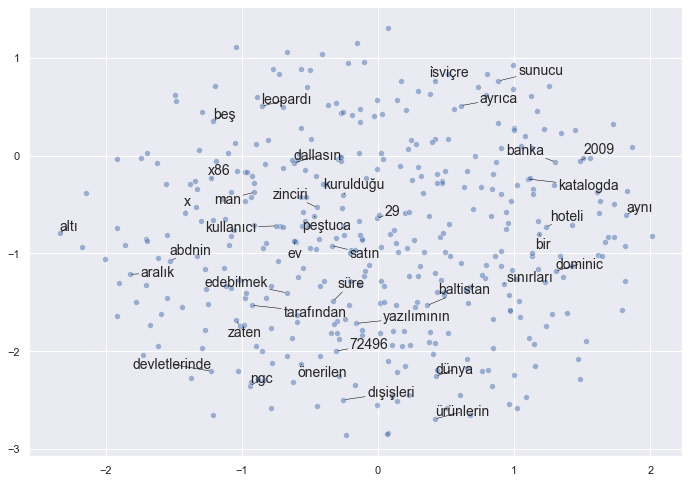

In [44]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()
